In [1]:
import numpy as np
print("NumPy version:", np.__version__)



NumPy version: 1.26.4


In [23]:
import tensorflow as tf
print(tf.__version__)


2.16.2


In [17]:
import os
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import re
import glob
from tqdm.auto import tqdm
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D,
    BatchNormalization,
    MaxPooling1D,
    GlobalAveragePooling1D,
    Bidirectional,
    LSTM,
    Dense,
    Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from collections import Counter

## Extra preprocessing for coordinates

In [2]:
# just learned that model can memorize specific locations on plate to classify, not good !
# solution : reset first frame as (0,0) and normalize by orientation ( so the direction of first movement is the same)
import matplotlib.pyplot as plt

def plot_trajectory(df, x_col="X", y_col="Y", title="Trajectory"):
    """
    Plot a 2D trajectory given a DataFrame with X/Y columns.
    """
    plt.figure(figsize=(6, 6))
    
    plt.plot(df[x_col], df[y_col], marker='o', markersize=2, linewidth=1)
    
    # Mark start and end
    plt.scatter(df[x_col].iloc[0], df[y_col].iloc[0], color='green', s=50, label="Start")
    plt.scatter(df[x_col].iloc[-1], df[y_col].iloc[-1], color='red', s=50, label="End")
    
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend()
    plt.axis('equal')  # important for not distorting shape
    plt.grid(True)
    plt.show()



def recenter_coordinates(df, x_col="X", y_col="Y"):
    """
    Center coordinates so that the first frame is at (0,0).
    Returns a copy of the df with new columns: X_centered, Y_centered.
    """
    df = df.copy()
    x0, y0 = df[x_col].iloc[0], df[y_col].iloc[0]
    df["X_centered"] = df[x_col] - x0
    df["Y_centered"] = df[y_col] - y0
    return df

def rotate_to_initial_heading(df, x_col="X_centered", y_col="Y_centered"):
    """
    Rotate the centered coordinates so the initial movement direction is aligned with angle 0.
    Returns df with new columns: X_rot, Y_rot.
    """

    df = df.copy()

    # Compute initial displacement (need at least 2 frames)
    dx = df[x_col].iloc[1] - df[x_col].iloc[0]
    dy = df[y_col].iloc[1] - df[y_col].iloc[0]

    # Angle of initial heading
    theta = np.arctan2(dy, dx)

    # Rotation matrix to align with 0 radians
    c, s = np.cos(-theta), np.sin(-theta)
    R = np.array([[c, -s],
                  [s,  c]])

    # Apply rotation
    coords = df[[x_col, y_col]].values.T  # shape (2, timesteps)
    rotated = R @ coords                   # matrix multiplication

    df["X_rot"] = rotated[0]
    df["Y_rot"] = rotated[1]

    return df



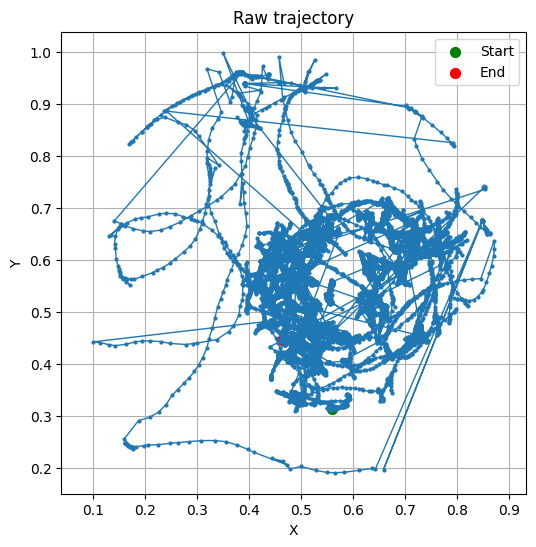

In [86]:
df_raw = pd.read_csv("preprocessed_data/full/coordinates_highestspeed_20250205_9_3_with_time_speed-preprocessed.csv")
plot_trajectory(df_raw, x_col="X", y_col="Y", title="Raw trajectory")


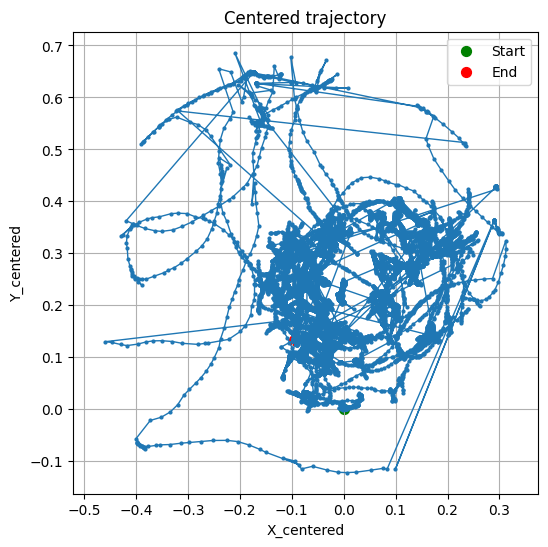

In [87]:
df_centered = recenter_coordinates(df_raw)
plot_trajectory(df_centered, x_col="X_centered", y_col="Y_centered",
                title="Centered trajectory")


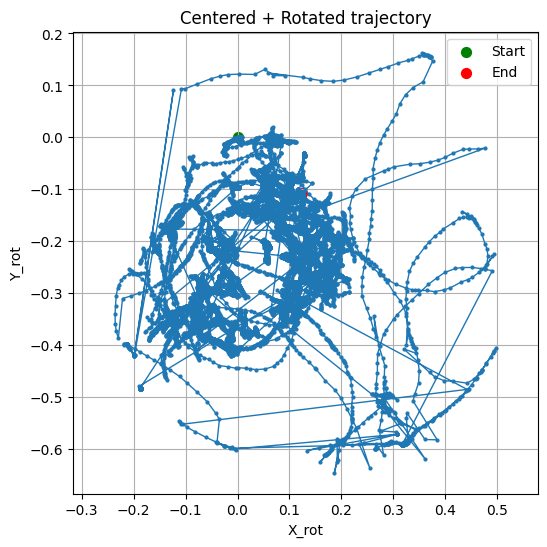

In [88]:
df_rot = rotate_to_initial_heading(df_centered)
plot_trajectory(df_rot, x_col="X_rot", y_col="Y_rot",
                title="Centered + Rotated trajectory")


In [3]:
#loading data A GARDER POUR LOADING DATA FROM FOLDER

SEGMENTS_DIR = "preprocessed_data/segments"
FULL_DIR = "preprocessed_data/full"
DATA_DIR = os.path.join(os.getcwd(), "TERBINAFINE")
LIFESPAN_FILE = os.path.join(DATA_DIR, "lifespan_summary.csv")
SEGMENT_LENGTH = 900 
FEATURE_COLS = ['dx', 'dy', 'Speed', 'turning_angle'] 
#FEATURE_COLS = ['X', 'Y'] 
KEEP_SEGMENTS_WITH_DEATH_INSIDE = True

print(len(os.listdir(SEGMENTS_DIR)), "files found")
print(os.listdir(SEGMENTS_DIR)[:5])

8150 files found
['coordinates_highestspeed_20250205_9_3_with_time_speed-fragment4.0-preprocessed.csv', 'coordinates_highestspeed_20240924_11_1_with_time_speed-fragment33.0-preprocessed.csv', 'coordinates_highestspeed_20240924_12_6_with_time_speed-fragment19.0-preprocessed.csv', 'coordinates_highestspeed_20250415_9_1_with_time_speed-fragment56.0-preprocessed.csv', 'coordinates_highestspeed_20250205_12_5_with_time_speed-fragment5.0-preprocessed.csv']


In [4]:
all_segment_dfs = []
seg_files = sorted(os.listdir(SEGMENTS_DIR))

for fname in tqdm(seg_files):
    if not fname.endswith(".csv"):
        continue

    df = pd.read_csv(os.path.join(SEGMENTS_DIR, fname))
    all_segment_dfs.append(df)

centered_dfs = [recenter_coordinates(df) for df in all_segment_dfs]
rotated_dfs = [rotate_to_initial_heading(df) for df in centered_dfs]





100%|██████████| 8150/8150 [00:15<00:00, 527.80it/s]


In [5]:
# adding displacement to represent pure movement
for df in rotated_dfs:
    df["dx"] = df["X_rot"].diff().fillna(0)
    df["dy"] = df["Y_rot"].diff().fillna(0)


In [20]:
rotated_dfs[0].head()

,GlobalFrame,Timestamp,Speed,X,Y,condition,source_file,Segment_index,turning_angle,worm_id,Segment,X_centered,Y_centered,X_rot,Y_rot,dx,dy
0,2.0,2024-08-27T15:43:40.009947,-0.424172,0.415679,0.405714,control,coordinates_highestspeed_20240827_10_1_with_ti...,0.0,0.000000,20240827_piworm10_1,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
1,3.0,2024-08-27T15:43:42.001966,-0.424172,0.416102,0.405726,control,coordinates_highestspeed_20240827_10_1_with_ti...,0.0,-0.215921,20240827_piworm10_1,0.0,0.000423,0.000013,0.000424,3.761451e-22,0.000424,3.761451e-22
2,4.0,2024-08-27T15:43:44.002485,-0.495096,0.416319,0.405562,control,coordinates_highestspeed_20240827_10_1_with_ti...,0.0,-0.200451,20240827_piworm10_1,0.0,0.000640,-0.000152,0.000635,-1.706355e-04,0.000212,-1.706355e-04
3,5.0,2024-08-27T15:43:46.002854,-0.401777,0.416455,0.405110,control,coordinates_highestspeed_20240827_10_1_with_ti...,0.0,0.198548,20240827_piworm10_1,0.0,0.000776,-0.000603,0.000758,-6.259191e-04,0.000122,-4.552837e-04
4,6.0,2024-08-27T15:43:48.002383,-0.512398,0.416641,0.404967,control,coordinates_highestspeed_20240827_10_1_with_ti...,0.0,-0.173521,20240827_piworm10_1,0.0,0.000962,-0.000746,0.000940,-7.744318e-04,0.000182,-1.485126e-04


In [6]:
#prepare preprocessed data for model
X_seg_list = []
y_seg_list = []
worm_ids =[]

for df in rotated_dfs:
     # get condition label
    label = df["condition"].iloc[0]
    worm_id = df["worm_id"].iloc[0]

    # extract features
    seg = df[FEATURE_COLS].values

    # --- handle variable length segments ---
    if len(seg) < SEGMENT_LENGTH:
        # pad with zeros
        pad_len = SEGMENT_LENGTH - len(seg)
        seg = np.pad(seg, ((0, pad_len), (0, 0)), mode="constant")
    else:
        # truncate
        seg = seg[:SEGMENT_LENGTH]

    X_seg_list.append(seg)
    y_seg_list.append(label)
    worm_ids.append(worm_id)

X_seg = np.array(X_seg_list)   # shape: (n_segments, TIMESTEPS, 4)
y_seg = np.array(y_seg_list)
worm_ids = np.array(worm_ids)

print("X shape:", X_seg.shape)
print("y shape:", y_seg.shape)
print("worm_ids shape:", worm_ids.shape)

X shape: (8150, 900, 4)
y shape: (8150,)
worm_ids shape: (8150,)


## loading data from preprocessed folder

In [69]:
X_seg_list = []
y_seg_list = []
worm_ids =[]

seg_files = sorted(os.listdir(SEGMENTS_DIR))

for fname in tqdm(seg_files):
    if not fname.endswith(".csv"):
        continue

    df = pd.read_csv(os.path.join(SEGMENTS_DIR, fname))

    # get condition label
    label = df["condition"].iloc[0]
    worm_id = df["worm_id"].iloc[0]

    # extract features
    seg = df[FEATURE_COLS].values

    # --- handle variable length segments ---
    if len(seg) < SEGMENT_LENGTH:
        # pad with zeros
        pad_len = SEGMENT_LENGTH - len(seg)
        seg = np.pad(seg, ((0, pad_len), (0, 0)), mode="constant")
    else:
        # truncate
        seg = seg[:SEGMENT_LENGTH]

    X_seg_list.append(seg)
    y_seg_list.append(label)
    worm_ids.append(worm_id)

X_seg = np.array(X_seg_list)   # shape: (n_segments, TIMESTEPS, 4)
y_seg = np.array(y_seg_list)
worm_ids = np.array(worm_ids)

print("X shape:", X_seg.shape)
print("y shape:", y_seg.shape)
print("worm_ids shape:", worm_ids.shape)


100%|██████████| 8150/8150 [00:20<00:00, 397.92it/s]


X shape: (8150, 900, 2)
y shape: (8150,)
worm_ids shape: (8150,)


In [7]:
# label encoding

le = LabelEncoder()
y_seg_encoded = le.fit_transform(y_seg)

print("Original labels:", np.unique(y_seg))
print("Encoded labels:", np.unique(y_seg_encoded))
print("Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

#class is balanced ?
(unique, counts) = np.unique(y_seg_encoded, return_counts=True)
print(dict(zip(unique, counts)))



Original labels: ['control' 'terbinafine']
Encoded labels: [0 1]
Mapping: {'control': 0, 'terbinafine': 1}
{0: 4074, 1: 4076}


In [8]:
#sgroup segments by worm ids to prevent data leakage

unique_worms = np.unique(worm_ids)
print("Total worms:", len(unique_worms))

worm_to_label = {}

# compute one condition label per worm
for w in unique_worms:
    # find any segment for that worm
    idx = np.where(worm_ids == w)[0][0]
    worm_to_label[w] = y_seg_encoded[idx]

worm_labels = np.array([worm_to_label[w] for w in unique_worms])

# stratification 20% test
train_worms, test_worms = train_test_split(
    unique_worms,
    test_size=0.2,
    random_state=42,
    stratify=worm_labels
)

# split again for validation inside model
worm_labels_for_train = np.array([worm_to_label[w] for w in train_worms])

train_worms_final, val_worms = train_test_split(
    train_worms,
    test_size=0.2,
    random_state=42,
    stratify=worm_labels_for_train
)


Total worms: 104


In [9]:
# build X and y train, validation and test

seg_train_mask = np.isin(worm_ids, train_worms_final)
seg_val_mask = np.isin(worm_ids, val_worms)
seg_test_mask  = np.isin(worm_ids, test_worms)

X_seg_train = X_seg[seg_train_mask]
X_seg_val = X_seg[seg_val_mask]
X_seg_test  = X_seg[seg_test_mask]

y_seg_train = y_seg_encoded[seg_train_mask]
y_seg_val = y_seg_encoded[seg_val_mask]
y_seg_test  = y_seg_encoded[seg_test_mask]

print("Train shape:", X_seg_train.shape)
print("Val shape:", X_seg_val.shape)
print("Test shape:",  X_seg_test.shape)


Train shape: (5049, 900, 4)
Val shape: (1403, 900, 4)
Test shape: (1698, 900, 4)


In [10]:
# make sure no worm is in the two sets !!! triple cheeeck

print("Overlap train/val:", np.intersect1d(train_worms_final, val_worms))
print("Overlap train/test:", np.intersect1d(train_worms_final, test_worms))
print("Overlap val/test:", np.intersect1d(val_worms, test_worms))



Overlap train/val: []
Overlap train/test: []
Overlap val/test: []


## 1-D CNN

In [27]:
# build 1-D CNN
model = Sequential([
    Conv1D(32, 7, activation='relu', padding='same', input_shape=(900, 4)),
    BatchNormalization(),
    Dropout(0.2),
    MaxPooling1D(2),

    Conv1D(64, 5, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.2),
    MaxPooling1D(2),

    Conv1D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),
    MaxPooling1D(2),

    GlobalAveragePooling1D(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])


model.compile(
    optimizer=Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/Users/jonathancarlucci/miniforge3/envs/ml_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 900, 32)        │           928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 900, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 900, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 450, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 450, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 450, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 450, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 225, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 225, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 225, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 225, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 112, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,473 (208.88 KB)

 Trainable params: 53,025 (207.13 KB)

 Non-trainable params: 448 (1.75 KB)

In [22]:
# define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=5,
        min_lr=1e-6
    ),
   # ModelCheckpoint(
   #     "best_model.keras",
   #     monitor='val_loss',
   #     save_best_only=True
   # )
]

In [29]:
# train model
history = model.fit(
    X_seg_train,
    y_seg_train,
    validation_data=(X_seg_val, y_seg_val), 
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.5144 - loss: 0.8026 - val_accuracy: 0.4569 - val_loss: 0.7675 - learning_rate: 0.0010
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.5062 - loss: 0.7787 - val_accuracy: 0.4569 - val_loss: 0.8251 - learning_rate: 0.0010
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5052 - loss: 0.7522 - val_accuracy: 0.4569 - val_loss: 0.7891 - learning_rate: 0.0010
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5167 - loss: 0.7324 - val_accuracy: 0.5232 - val_loss: 0.7257 - learning_rate: 0.0010
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5237 - loss: 0.7127 - val_accuracy: 0.5396 - val_loss: 0.7088 - learning_rate: 0.0010
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5262 - loss: 0.7062 - val_accuracy: 0.5303 - val_loss: 0.7073 - learning_rate: 0.0010
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5270 - l

In [30]:
test_loss, test_acc = model.evaluate(X_seg_test, y_seg_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")


Test accuracy: 0.5088
Test loss: 0.6894


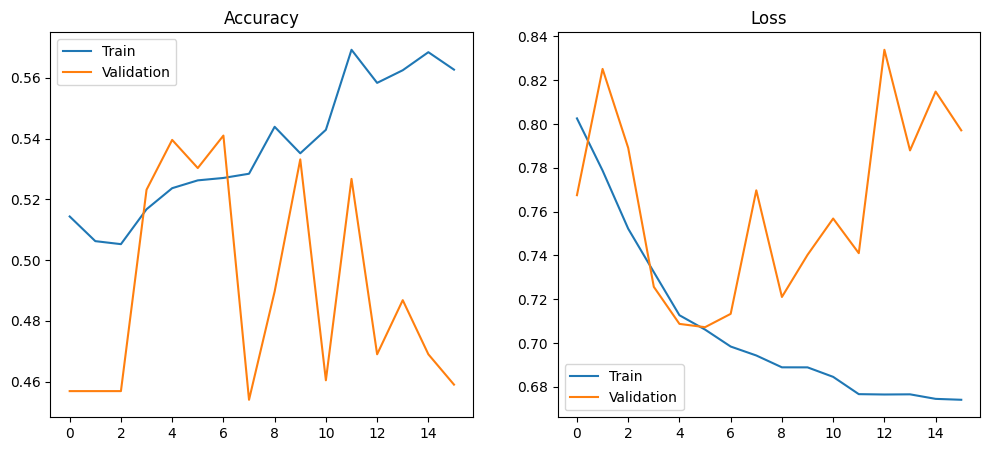

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.legend()

plt.show()


In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = (model.predict(X_seg_test) > 0.5).astype(int)

print(confusion_matrix(y_seg_test, y_pred))
print(classification_report(y_seg_test, y_pred))


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
[[379 497]
 [337 485]]
              precision    recall  f1-score   support

           0       0.53      0.43      0.48       876
           1       0.49      0.59      0.54       822

    accuracy                           0.51      1698
   macro avg       0.51      0.51      0.51      1698
weighted avg       0.51      0.51      0.51      1698



## LSTM

In [34]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(900, 4)),
    Dropout(0.3),

    LSTM(32),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/Users/jonathancarlucci/miniforge3/envs/ml_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 900, 64)        │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 900, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,169 (121.75 KB)

 Trainable params: 31,169 (121.75 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history = model.fit(
    X_seg_train,
    y_seg_train,
    validation_data=(X_seg_val, y_seg_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.4969 - loss: 0.6950 - val_accuracy: 0.4604 - val_loss: 0.6966 - learning_rate: 0.0010
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.5015 - loss: 0.6946 - val_accuracy: 0.4562 - val_loss: 0.6968 - learning_rate: 0.0010
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.4890 - loss: 0.6941 - val_accuracy: 0.4690 - val_loss: 0.6969 - learning_rate: 0.0010
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.4892 - loss: 0.6946 - val_accuracy: 0.5203 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.5009 - loss: 0.6943 - val_accuracy: 0.4576 - val_loss: 0.6941 - learning_rate: 0.0010
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.5060 - loss: 0.6936 - val_accuracy: 0.4569 - val_loss: 0.6975 - learning_rate: 0.0010
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy:

In [36]:
test_loss, test_acc = model.evaluate(X_seg_test, y_seg_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")


Test accuracy: 0.5047
Test loss: 0.6930


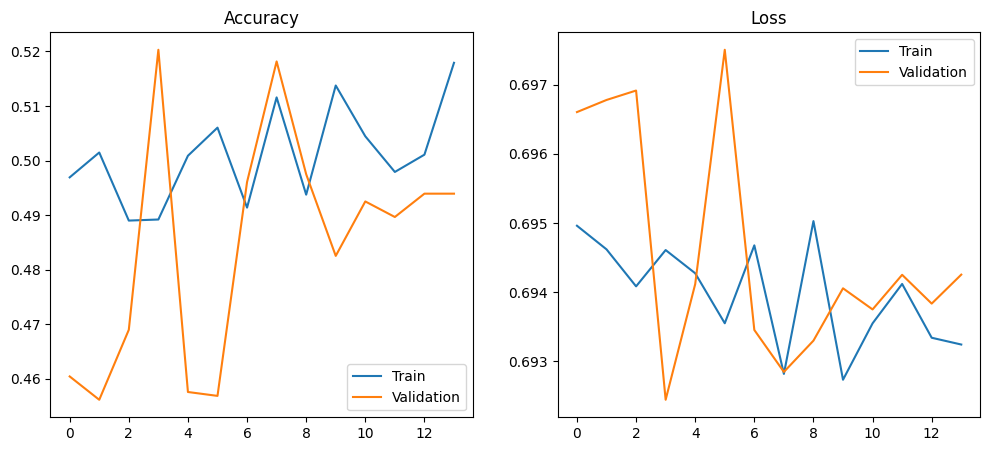

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.legend()

plt.show()


## CNN-LSTM hybrid

In [11]:


model = Sequential([
    # --- CNN Feature Extractor ---
    Conv1D(32, kernel_size=7, padding='same', activation='relu', input_shape=(900, 4)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Dropout(0.3),

    # --- LSTM Temporal Reasoning ---
    LSTM(64, return_sequences=False),
    Dropout(0.3),

    # --- Dense Classifier ---
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/Users/jonathancarlucci/miniforge3/envs/ml_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-28 13:42:58.008381: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-11-28 13:42:58.008941: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-28 13:42:58.009311: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-28 13:42:58.009635: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-28 13:42:58.009652: I tensorflow/core/common_runtime/pluggable_device/pluggab

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 900, 32)        │           928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 900, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 450, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 450, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 450, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 225, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 225, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 225, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 112, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,465 (353.38 KB)

 Trainable params: 90,017 (351.63 KB)

 Non-trainable params: 448 (1.75 KB)

In [23]:
history = model.fit(
    X_seg_train,
    y_seg_train,
    validation_data=(X_seg_val, y_seg_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5407 - loss: 0.6895 - val_accuracy: 0.5488 - val_loss: 0.6937 - learning_rate: 9.0000e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5502 - loss: 0.6841 - val_accuracy: 0.5417 - val_loss: 0.6944 - learning_rate: 9.0000e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5611 - loss: 0.6829 - val_accuracy: 0.5203 - val_loss: 0.6948 - learning_rate: 9.0000e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.5548 - loss: 0.6829 - val_accuracy: 0.5167 - val_loss: 0.6945 - learning_rate: 9.0000e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5643 - loss: 0.6778 - val_accuracy: 0.5431 - val_loss: 0.6951 - learning_rate: 9.0000e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5617 - loss: 0.6765 - val_accuracy: 0.5153 - val_loss: 0.6953 - learning_rate: 9.0000e-05
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/ste

In [24]:
test_loss, test_acc = model.evaluate(X_seg_test, y_seg_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")


Test accuracy: 0.5318


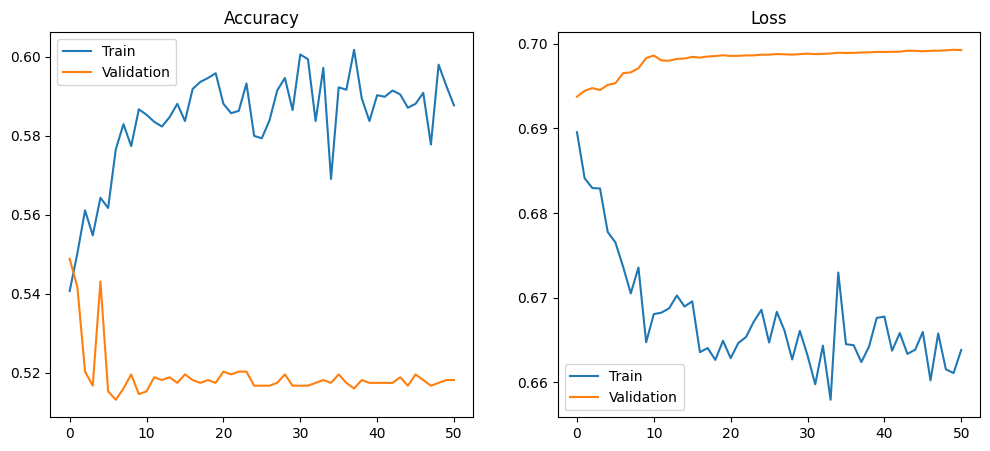

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.legend()

plt.show()


## BiLSTM

In [18]:
model_bilstm = Sequential([
    # ----- CNN feature extractor -----
    Conv1D(32, kernel_size=7, padding='same', activation='relu',
           input_shape=(900, 4)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Dropout(0.3),

    # ----- Bidirectional LSTM -----
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),

    # ----- Dense classifier -----
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')   # binary output
])

model_bilstm.compile(
    optimizer=Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_bilstm.summary()

/Users/jonathancarlucci/miniforge3/envs/ml_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 900, 32)        │           928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 900, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 450, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 450, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 450, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 225, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 225, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 225, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 112, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 112, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,969 (562.38 KB)

 Trainable params: 143,521 (560.63 KB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
history_bilstm = model_bilstm.fit(
    X_seg_train,
    y_seg_train,
    validation_data=(X_seg_val, y_seg_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.5106 - loss: 0.7305 - val_accuracy: 0.4626 - val_loss: 0.7234 - learning_rate: 0.0010
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.5152 - loss: 0.7201 - val_accuracy: 0.4989 - val_loss: 0.7047 - learning_rate: 0.0010
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.5233 - loss: 0.7118 - val_accuracy: 0.4897 - val_loss: 0.7077 - learning_rate: 0.0010
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.5308 - loss: 0.7018 - val_accuracy: 0.5453 - val_loss: 0.6988 - learning_rate: 0.0010
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.5288 - loss: 0.6964 - val_accuracy: 0.5167 - val_loss: 0.7137 - learning_rate: 0.0010
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.5573 - loss: 0.6846 - val_accuracy: 0.5196 - val_loss: 0.7118 - learning_rate: 3.0000e-04
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy:

In [20]:
test_loss, test_acc = model_bilstm.evaluate(X_seg_test, y_seg_test, verbose=0)
print(f"BiLSTM Test accuracy: {test_acc:.4f}")
print(f"BiLSTM Test loss: {test_loss:.4f}")


BiLSTM Test accuracy: 0.5165
BiLSTM Test loss: 0.7026


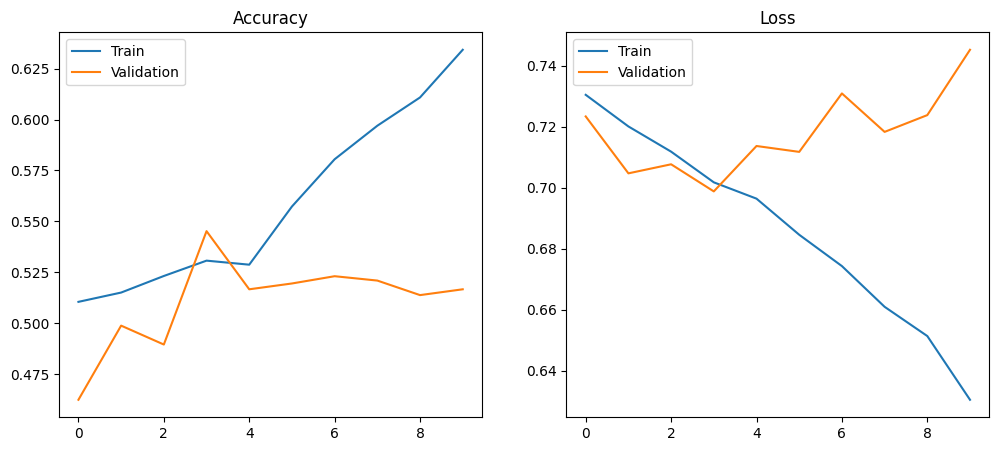

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_bilstm.history['accuracy'], label='Train')
plt.plot(history_bilstm.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_bilstm.history['loss'], label='Train')
plt.plot(history_bilstm.history['val_loss'], label='Validation')
plt.title("Loss")
plt.legend()

plt.show()

After removing position leaks (centering, rotation), the underlying behavioral signal is weak and noisy.
Deep models (CNN, LSTM, BiLSTM) are not extracting enough discriminative information from raw (X, Y, speed, turning) trajectories alone.